In [1]:
import os
import random
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Dense
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np


In [2]:
#Hyperparameters

learning_rate = 0.003
meta_step_size = 0.25

inner_batch_size = 25
eval_batch_size = 25

meta_iters = 2000
eval_iters = 5
inner_iters = 4

eval_interval = 1
train_shots = 20
shots = 5
classes = 46

In [3]:
# # Paths to the original dataset
# original_train_dir = r'C:\Users\91969\Downloads\HindiHandWrittern_Recognition\DevanagariHandwrittenCharacterDataset\Train'
# original_test_dir = r'C:\Users\91969\Downloads\HindiHandWrittern_Recognition\DevanagariHandwrittenCharacterDataset\Test'

# # Paths for the new dataset
# new_train_dir = r'D:\Hindi_Handwritten_Recognition\HR_Dataset\Train'
# new_test_dir = r'D:\Hindi_Handwritten_Recognition\HR_Dataset\Test'

# # Number of images to select
# train_sample_size = 150
# test_sample_size = 50

# # Create the new folder structure
# os.makedirs(new_train_dir, exist_ok=True)
# os.makedirs(new_test_dir, exist_ok=True)

In [4]:
class HindiHandwrittenDataset:
    def __init__(self, data_dir):
        # Initialize dataset, loading images and labels from the provided directory
        self.data = {}
        self.labels = []

        # Walk through the directories for train/test images
        for root, dirs, files in os.walk(data_dir):
            for subfolder in dirs:
                label = subfolder
                image_dir = os.path.join(root, subfolder)
                images = []
                
                # Load images from subfolders
                for img_file in os.listdir(image_dir):
                    img_path = os.path.join(image_dir, img_file)
                    img = load_img(img_path, color_mode='grayscale', target_size=(32, 32))
                    img_array = img_to_array(img) / 255.0  # Normalize the image
                    images.append(img_array)

                self.data[label] = np.array(images)
                self.labels.append(label)
                

    def get_mini_dataset(self, batch_size, repetitions, shots, classes, split=False):
        # Prepare arrays to store the randomly selected images and labels
        temp_labels = np.zeros(shape=(classes * shots))
        temp_images = np.zeros(shape=(classes * shots, 32, 32, 1))

        if split:
            test_labels = np.zeros(shape=(classes))
            test_images = np.zeros(shape=(classes, 32, 32, 1))

        # Randomly select a subset of labels from the available classes
        label_subset = random.sample(self.labels, k=classes)
        
        for class_idx, class_label in enumerate(label_subset):
            # Assign temporary numeric labels
            temp_labels[class_idx * shots:(class_idx + 1) * shots] = class_idx

            # If split is enabled, reserve one extra image for testing
            if split:
                images_to_split = random.sample(list(self.data[class_label]), k=shots + 1)
                test_images[class_idx] = images_to_split[-1]  # Use last image for testing
                temp_images[class_idx * shots:(class_idx + 1) * shots] = images_to_split[:-1]
                test_labels[class_idx] = class_idx
            else:
                # Randomly sample 'shots' images per class
                temp_images[class_idx * shots:(class_idx + 1) * shots] = random.sample(
                    list(self.data[class_label]), k=shots)

        # Convert to TensorFlow dataset for batching and shuffling
        dataset = tf.data.Dataset.from_tensor_slices(
            (temp_images.astype(np.float32), temp_labels.astype(np.int32))
        )
        dataset = dataset.shuffle(100).batch(batch_size).repeat(repetitions)

        if split:
            return dataset, test_images, test_labels
        return dataset

# Example usage:
train_data_dir = r'/kaggle/input/hr-dataset/HR_Dataset/Train'
test_data_dir = r'/kaggle/input/hr-dataset/HR_Dataset/Test'

# Load your Hindi dataset
train_dataset = HindiHandwrittenDataset(train_data_dir)
test_dataset = HindiHandwrittenDataset(test_data_dir)

repetitions = 5
batch_size = 32

mini_train_dataset, mini_test_images, mini_test_labels = train_dataset.get_mini_dataset(
    batch_size=batch_size,
    repetitions=repetitions,
    shots=shots,
    classes=classes,
    split=True
)


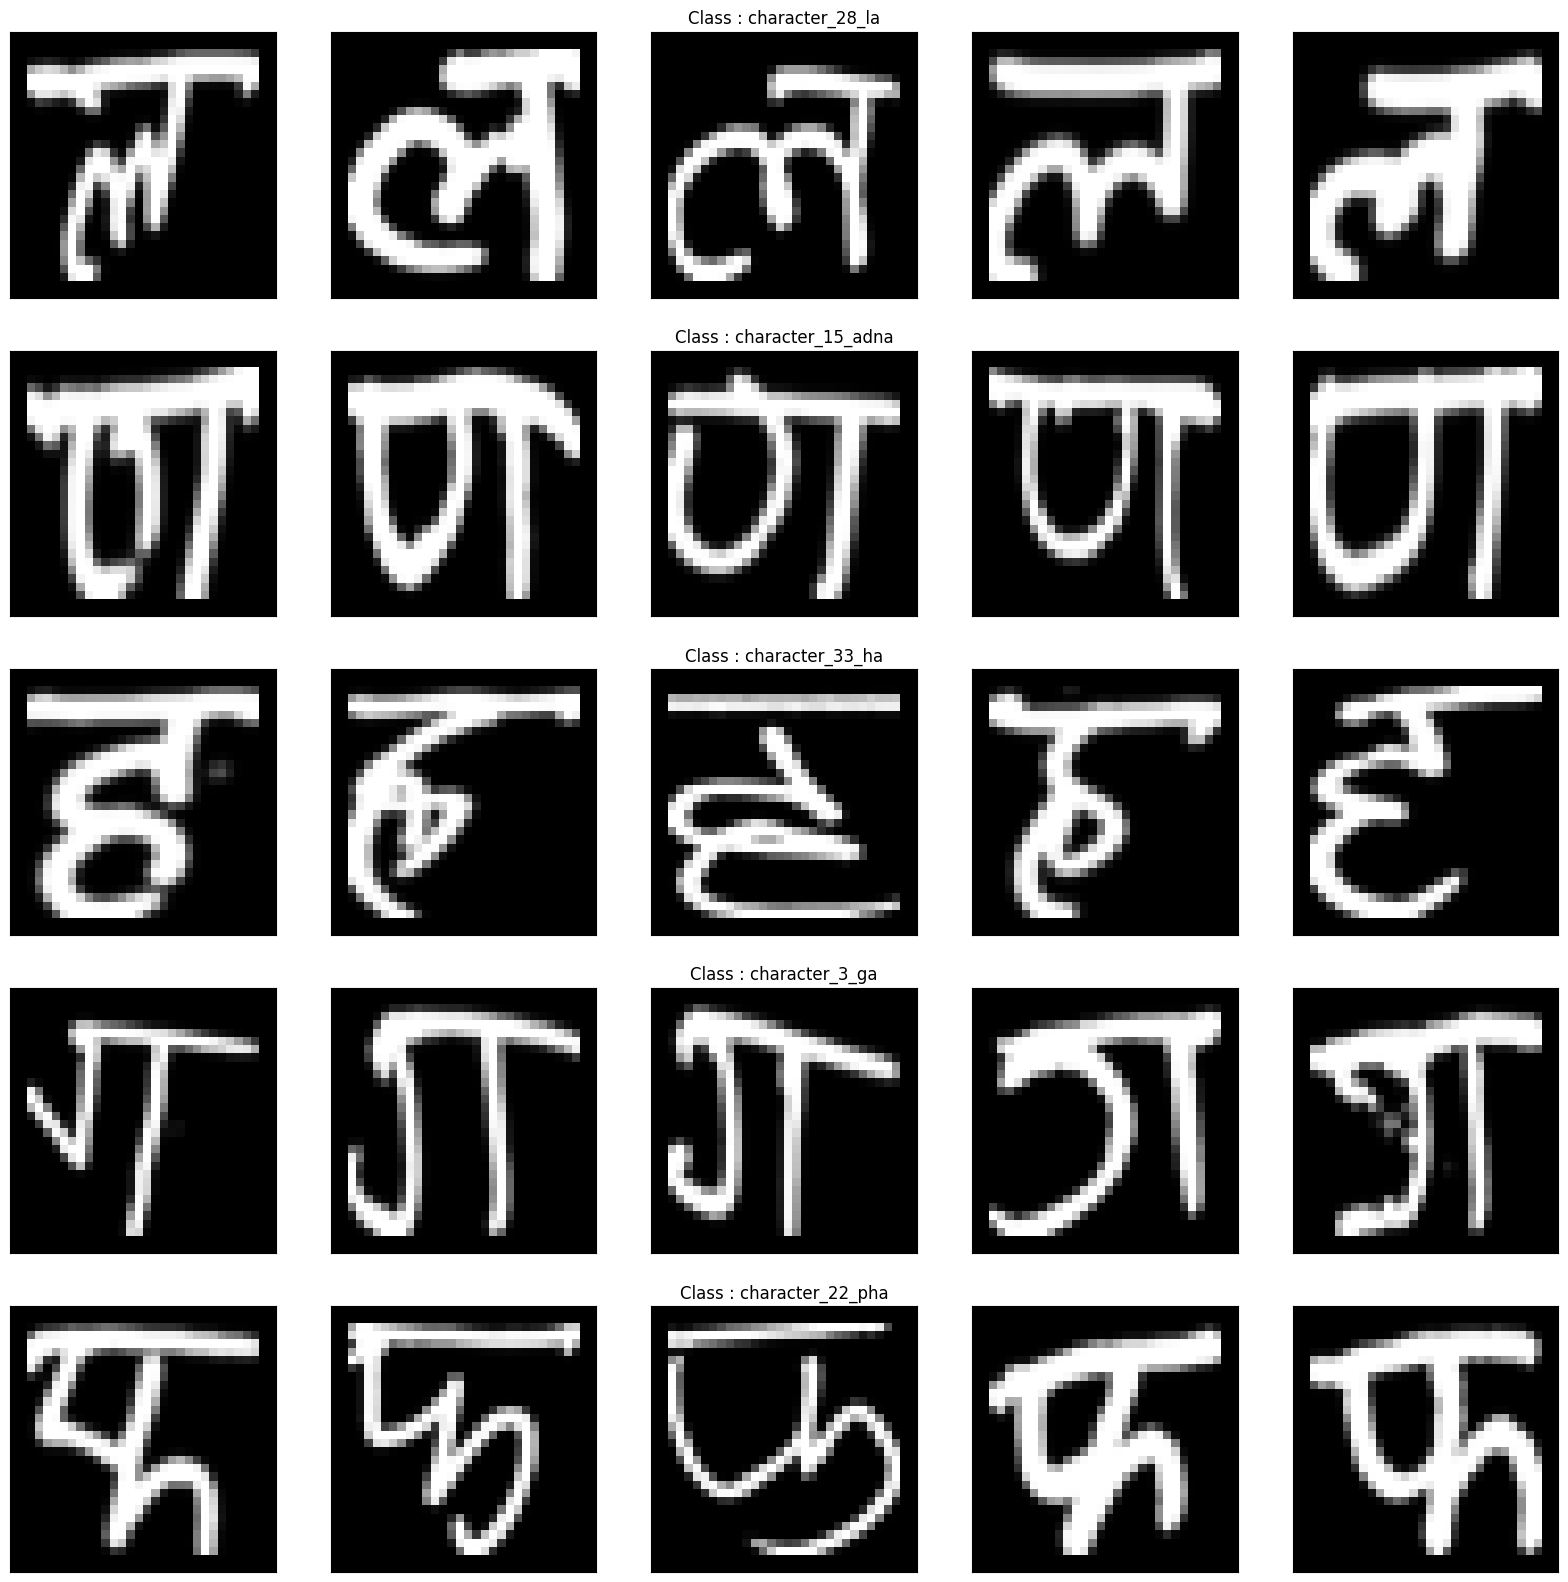

In [5]:
_, axarr = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

sample_keys = list(train_dataset.data.keys())

for a in range(5):
    for b in range(5):
        temp_image = train_dataset.data[sample_keys[a]][b]
        temp_image = np.stack((temp_image[:, :, 0],) * 3, axis=2)
        temp_image *= 255
        temp_image = np.clip(temp_image, 0, 255).astype("uint8")
        if b == 2:
            axarr[a, b].set_title("Class : " + sample_keys[a])
        axarr[a, b].imshow(temp_image, cmap="gray")
        axarr[a, b].xaxis.set_visible(False)
        axarr[a, b].yaxis.set_visible(False)
plt.show()

**BUILD THE MODEL**

In [6]:
def conv_bn(x):
    x = layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    return layers.ReLU()(x)


inputs = layers.Input(shape=(32, 32, 1))
x = conv_bn(inputs)
x = conv_bn(x)
x = conv_bn(x)
x = conv_bn(x)
x = layers.Flatten()(x)
outputs = layers.Dense(classes, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile()
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)



**#TRAIN THE MODEL**

In [7]:
training = []
testing = []
for meta_iter in range(meta_iters):
    frac_done = meta_iter / meta_iters
    cur_meta_step_size = (1 - frac_done) * meta_step_size
    # Temporarily save the weights from the model.
    old_vars = model.get_weights()
    # Get a sample from the full dataset.
    mini_dataset = train_dataset.get_mini_dataset(
        inner_batch_size, inner_iters, train_shots, classes
    )
    for images, labels in mini_dataset:
        with tf.GradientTape() as tape:
            preds = model(images)
            loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
    new_vars = model.get_weights()
    # Perform SGD for the meta step.
    for var in range(len(new_vars)):
        new_vars[var] = old_vars[var] + (
            (new_vars[var] - old_vars[var]) * cur_meta_step_size
        )
    # After the meta-learning step, reload the newly-trained weights into the model.
    model.set_weights(new_vars)
    # Evaluation loop
    if meta_iter % eval_interval == 0:
        accuracies = []
        for dataset in (train_dataset, test_dataset):
            # Sample a mini dataset from the full dataset.
            train_set, test_images, test_labels = dataset.get_mini_dataset(
                eval_batch_size, eval_iters, shots, classes, split=True
            )
            old_vars = model.get_weights()
            # Train on the samples and get the resulting accuracies.
            for images, labels in train_set:
                with tf.GradientTape() as tape:
                    preds = model(images)
                    loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
                grads = tape.gradient(loss, model.trainable_weights)
                optimizer.apply_gradients(zip(grads, model.trainable_weights))
            test_preds = model.predict(test_images)
            test_preds = tf.argmax(test_preds).numpy()
            num_correct = (test_preds == test_labels).sum()
            # Reset the weights after getting the evaluation accuracies.
            model.set_weights(old_vars)
            accuracies.append(num_correct / classes)
        training.append(accuracies[0])
        testing.append(accuracies[1])
        if meta_iter % 100 == 0:
            print(
                "batch %d: train=%f test=%f" % (meta_iter, accuracies[0], accuracies[1])
            )

I0000 00:00:1725792734.733865      68 service.cc:145] XLA service 0x7c7ca8004600 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725792734.733946      68 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1725792734.733951      68 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 764ms/step

I0000 00:00:1725792735.332675      68 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
batch 0: train=0.130435 test=0.021739
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━

In [8]:
print("Training Accuracy : ",training)
print("Testing Accuracy : ",testing)

Training Accuracy :  [0.13043478260869565, 0.06521739130434782, 0.17391304347826086, 0.17391304347826086, 0.17391304347826086, 0.2391304347826087, 0.3695652173913043, 0.32608695652173914, 0.2608695652173913, 0.43478260869565216, 0.3695652173913043, 0.2608695652173913, 0.41304347826086957, 0.41304347826086957, 0.30434782608695654, 0.32608695652173914, 0.5, 0.45652173913043476, 0.2826086956521739, 0.32608695652173914, 0.30434782608695654, 0.391304347826087, 0.45652173913043476, 0.32608695652173914, 0.5652173913043478, 0.43478260869565216, 0.5434782608695652, 0.34782608695652173, 0.41304347826086957, 0.43478260869565216, 0.43478260869565216, 0.3695652173913043, 0.5, 0.34782608695652173, 0.32608695652173914, 0.5869565217391305, 0.5434782608695652, 0.4782608695652174, 0.5434782608695652, 0.43478260869565216, 0.5, 0.5, 0.5434782608695652, 0.391304347826087, 0.5652173913043478, 0.5434782608695652, 0.6086956521739131, 0.6086956521739131, 0.5652173913043478, 0.5217391304347826, 0.56521739130434

**Visualise the results**

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


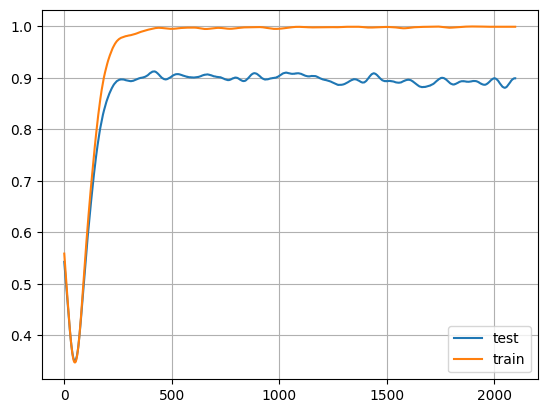

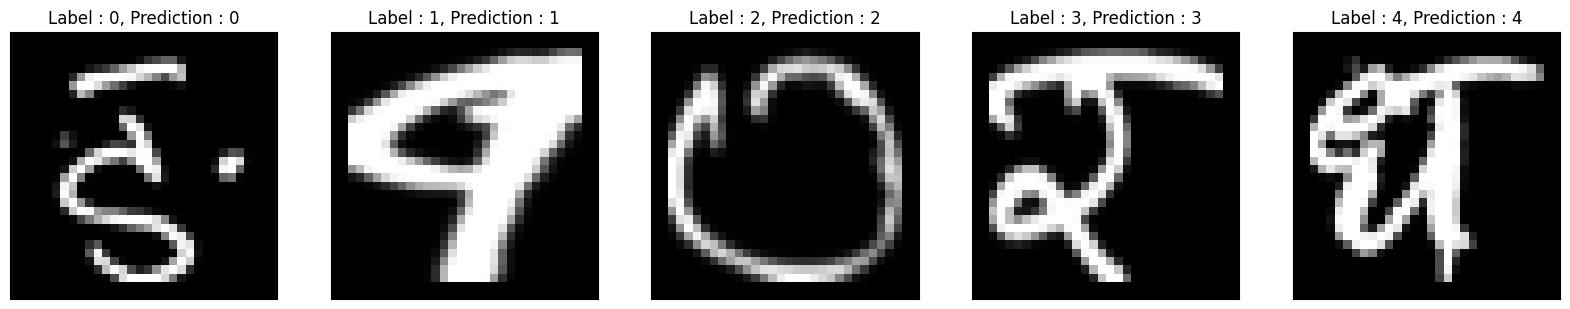

In [9]:
window_length = 100
train_s = np.r_[
    training[window_length - 1 : 0 : -1],
    training,
    training[-1:-window_length:-1],
]
test_s = np.r_[
    testing[window_length - 1 : 0 : -1], testing, testing[-1:-window_length:-1]
]
w = np.hamming(window_length)
train_y = np.convolve(w / w.sum(), train_s, mode="valid")
test_y = np.convolve(w / w.sum(), test_s, mode="valid")

# Display the training accuracies.
x = np.arange(0, len(test_y), 1)
plt.plot(x, test_y, x, train_y)
plt.legend(["test", "train"])
plt.grid()

train_set, test_images, test_labels = dataset.get_mini_dataset(
    eval_batch_size, eval_iters, shots, classes, split=True
)
for images, labels in train_set:
    with tf.GradientTape() as tape:
        preds = model(images)
        loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
test_preds = model.predict(test_images)
test_preds = tf.argmax(test_preds).numpy()

_, axarr = plt.subplots(nrows=1, ncols=5, figsize=(20, 20))

sample_keys = list(train_dataset.data.keys())

for i, ax in zip(range(5), axarr):
    temp_image = np.stack((test_images[i, :, :, 0],) * 3, axis=2)
    temp_image *= 255
    temp_image = np.clip(temp_image, 0, 255).astype("uint8")
    ax.set_title(
        "Label : {}, Prediction : {}".format(int(test_labels[i]), test_preds[i])
    )
    ax.imshow(temp_image, cmap="gray")
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.show()